# Training and Basic Evaluation for a 3D Binary Classifier

If using MedMNIST for the first time, you will need to install medmnist.

In [1]:
#!pip install medmnist

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

import medmnist
from medmnist import INFO

import sys
sys.path.insert(0,"../")

import dataset_without_pytorch

from functions import split_data, get_label_counts, build_basic_model, argmax_array, generate_training_mixup_images
from plotting_functions import plot_history

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


We set some of our parameters here. The data flag is 'pneumoniamnist' - a binary pneumonia dataset. 

In [3]:
data_flag = 'vesselmnist3d'

download = True

image_size = 28

info = INFO[data_flag]

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [4]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\vesselmnist3d.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\vesselmnist3d.npz


In [5]:
print(train_dataset)
print(test_dataset)

Dataset VesselMNIST3D (vesselmnist3d)
    Number of datapoints: 1335
    Root location: C:\Users\Will Poulett\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'vessel', '1': 'aneurysm'}
    Number of samples: {'train': 1335, 'val': 191, 'test': 382}
    Description: The VesselMNIST3D is based on an open-access 3D intracranial aneurysm dataset, IntrA, containing 103 3D models (meshes) of entire brain vessels collected by reconstructing MRA images. 1,694 healthy vessel segments and 215 aneurysm segments are generated automatically from the complete models. We fix the non-watertight mesh with PyMeshFix and voxelize the watertight mesh with trimesh into 28×28×28 voxels. We split the source dataset with a ratio of 7:1:2 into training, validation and test set.
    License: CC BY 4.0
Dataset VesselMNIST3D (vesselmnist3d)
    Number of datapoints: 382
    Root location: C:\Users\Will Poulett\.medmnist
    Split: test
    Task: binary-clas

Here we split our data into train, validation, and 2 testing datasets. One is for MUBA, one is for further evaluation. 

In [6]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED, one_hot_encoded = True, num_classes=2, image_size = image_size, three_d=True)

In [7]:
get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ['vessel', 'aneurysm'])


Train
{(0, 1): 150, (1, 0): 1185}  ['vessel', 'aneurysm']

Val
{(0, 1): 22, (1, 0): 169}  ['vessel', 'aneurysm']

Test A
{(0, 1): 13, (1, 0): 101}  ['vessel', 'aneurysm']

Test B
{(0, 1): 30, (1, 0): 238}  ['vessel', 'aneurysm']


## Basic Model 

This first model we call 'basic' as we are not augmenting the data in any way during training. 

In [8]:
model = build_basic_model(input_shape = (image_size,image_size, image_size), num_classes = 2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        8096      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        2

In [9]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./simple_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"simple_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [10]:
history = model.fit(X_train,y_train, batch_size = 32, epochs = 30 , validation_data = (X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/30
42/42 [==============================] - 3s 40ms/step - loss: 0.6032 - accuracy: 0.8382 - val_loss: 0.6604 - val_accuracy: 0.6178 - lr: 0.0010
Epoch 2/30
 3/42 [=>............................] - ETA: 1s - loss: 0.1823 - accuracy: 0.9375

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 1s 34ms/step - loss: 0.3098 - accuracy: 0.8869 - val_loss: 0.4040 - val_accuracy: 0.8796 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - 2s 36ms/step - loss: 0.2950 - accuracy: 0.8929 - val_loss: 0.3027 - val_accuracy: 0.9005 - lr: 0.0010
Epoch 4/30
42/42 [==============================] - 1s 35ms/step - loss: 0.2173 - accuracy: 0.9131 - val_loss: 0.3044 - val_accuracy: 0.9058 - lr: 0.0010
Epoch 5/30
42/42 [==============================] - 1s 35ms/step - loss: 0.1776 - accuracy: 0.9221 - val_loss: 0.3162 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 6/30
42/42 [==============================] - 2s 38ms/step - loss: 0.1449 - accuracy: 0.9453 - val_loss: 0.2901 - val_accuracy: 0.9058 - lr: 0.0010
Epoch 7/30
41/42 [============================>.] - ETA: 0s - loss: 0.1092 - accuracy: 0.9543
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
42/42 [==============================] - 2s 36ms/step - loss: 0.1092 - 

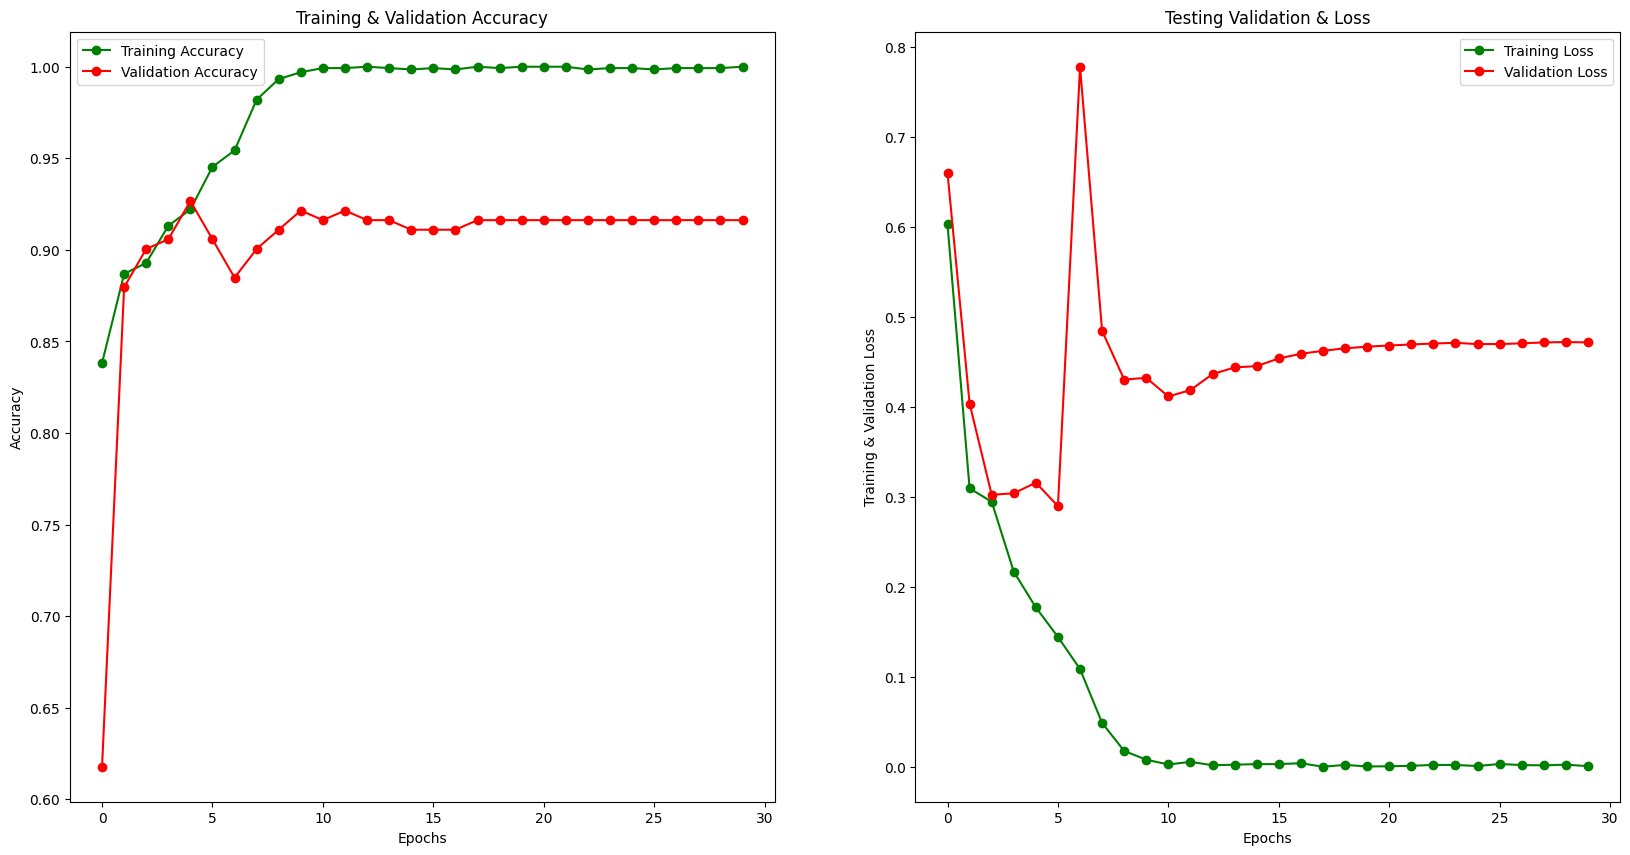

In [11]:
plot_history(history, size=(20,10), epochs = 30)

In [12]:
print(history.history["accuracy"])
print(history.history["loss"])
print(history.history["val_accuracy"])
print(history.history["val_loss"])

[0.8382022380828857, 0.8868913650512695, 0.8928838968276978, 0.9131085872650146, 0.922097384929657, 0.945318341255188, 0.9543071389198303, 0.9820224642753601, 0.9932584166526794, 0.9970037341117859, 0.9992509484291077, 0.9992509484291077, 1.0, 0.9992509484291077, 0.9985018968582153, 0.9992509484291077, 0.9985018968582153, 1.0, 0.9992509484291077, 1.0, 1.0, 1.0, 0.9985018968582153, 0.9992509484291077, 0.9992509484291077, 0.9985018968582153, 0.9992509484291077, 0.9992509484291077, 0.9992509484291077, 1.0]
[0.6032263040542603, 0.30984967947006226, 0.29502132534980774, 0.21732394397258759, 0.1776374876499176, 0.1448667198419571, 0.10917701572179794, 0.04928595572710037, 0.018173448741436005, 0.008435545489192009, 0.003161891596391797, 0.006108123809099197, 0.00232697487808764, 0.0029349320102483034, 0.0035464519169181585, 0.0035753250122070312, 0.004537629894912243, 0.0006677196943201125, 0.0026659786235541105, 0.0010064872913062572, 0.0011468111770227551, 0.0016836387803778052, 0.00269466

In [13]:
best_model = keras.models.load_model("./simple_models/best_model_epoch_06.h5")

In [14]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['vessel', 'aneurysm']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['vessel', 'aneurysm']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

9/9 [==============================] - 0s 10ms/step
Test Set A
              precision    recall  f1-score   support

      vessel       0.92      0.94      0.93       101
    aneurysm       0.45      0.38      0.42        13

    accuracy                           0.88       114
   macro avg       0.69      0.66      0.67       114
weighted avg       0.87      0.88      0.87       114


Test Set B
              precision    recall  f1-score   support

      vessel       0.92      0.95      0.94       238
    aneurysm       0.50      0.37      0.42        30

    accuracy                           0.89       268
   macro avg       0.71      0.66      0.68       268
weighted avg       0.88      0.89      0.88       268

Test Set A
[[95  6]
 [ 8  5]]

Test Set B
[[227  11]
 [ 19  11]]


In [15]:
best_model = keras.models.load_model("./simple_models/model_epoch_15.h5")

predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['vessel', 'aneurysm']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['vessel', 'aneurysm']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

9/9 [==============================] - 0s 8ms/step
Test Set A
              precision    recall  f1-score   support

      vessel       0.93      0.93      0.93       101
    aneurysm       0.46      0.46      0.46        13

    accuracy                           0.88       114
   macro avg       0.70      0.70      0.70       114
weighted avg       0.88      0.88      0.88       114


Test Set B
              precision    recall  f1-score   support

      vessel       0.94      0.95      0.95       238
    aneurysm       0.59      0.53      0.56        30

    accuracy                           0.91       268
   macro avg       0.77      0.74      0.75       268
weighted avg       0.90      0.91      0.90       268

Test Set A
[[94  7]
 [ 7  6]]

Test Set B
[[227  11]
 [ 14  16]]


## Advanced Model

We call this model 'advanced' as we will use datagen to augment the data each epoch. We use random rotation, width adn height shifts, and horizontal flips. 

In [16]:
model = build_basic_model(input_shape = (image_size,image_size,image_size), num_classes = 2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        8096      
                                                                 
 batch_normalization_5 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_6 (Bat  (None, 14, 14, 64)       

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:2092: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1335, 28, 28, 28) (28 channels).
  warnings.warn(


In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./advance_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./advance_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [19]:
history_2 = model.fit(datagen.flow(X_train,y_train, batch_size = 32), epochs = 30 ,  validation_data = (X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)


Epoch 1/30


c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1335, 28, 28, 28) (28 channels).
  warnings.warn(


42/42 [==============================] - 4s 67ms/step - loss: 0.4687 - accuracy: 0.8517 - val_loss: 0.4248 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 2/30
 1/42 [..............................] - ETA: 2s - loss: 0.3115 - accuracy: 0.8696

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 3s 62ms/step - loss: 0.3258 - accuracy: 0.8846 - val_loss: 0.3203 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8876
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
42/42 [==============================] - 3s 63ms/step - loss: 0.3178 - accuracy: 0.8876 - val_loss: 0.4192 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 4/30
42/42 [==============================] - 3s 64ms/step - loss: 0.2761 - accuracy: 0.8869 - val_loss: 0.3893 - val_accuracy: 0.8848 - lr: 3.0000e-04
Epoch 5/30
42/42 [==============================] - 3s 60ms/step - loss: 0.2507 - accuracy: 0.8959 - val_loss: 0.3244 - val_accuracy: 0.8901 - lr: 3.0000e-04
Epoch 6/30
42/42 [==============================] - 3s 62ms/step - loss: 0.2441 - accuracy: 0.8974 - val_loss: 0.3059 - val_accuracy: 0.8848 - lr: 3.0000e-04
Epoch 7/30
42/42 [==============================] - ETA: 0s - loss: 0.

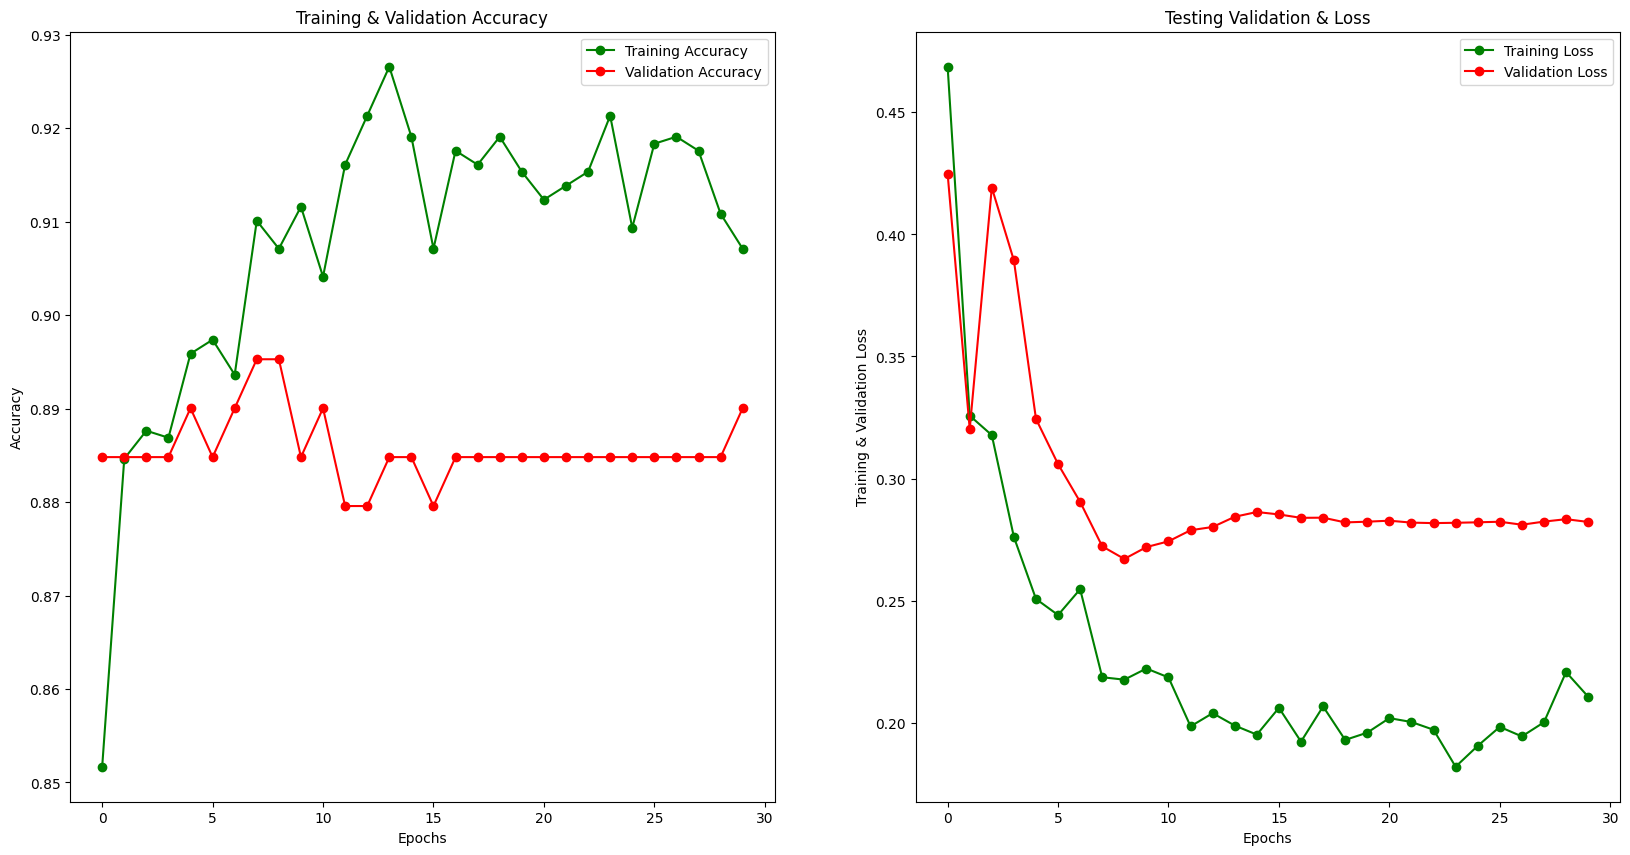

In [21]:
plot_history(history_2, size=(20,10), epochs = 30)

In [22]:
best_model = keras.models.load_model("./advance_models/best_model_epoch_09.h5")

In [23]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['vessel', 'aneurysm']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['vessel', 'aneurysm']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

9/9 [==============================] - 0s 9ms/step
Test Set A
              precision    recall  f1-score   support

      vessel       0.93      0.96      0.95       101
    aneurysm       0.60      0.46      0.52        13

    accuracy                           0.90       114
   macro avg       0.77      0.71      0.73       114
weighted avg       0.89      0.90      0.90       114


Test Set B
              precision    recall  f1-score   support

      vessel       0.92      0.98      0.95       238
    aneurysm       0.67      0.33      0.44        30

    accuracy                           0.91       268
   macro avg       0.79      0.66      0.70       268
weighted avg       0.89      0.91      0.89       268

Test Set A
[[97  4]
 [ 7  6]]

Test Set B
[[233   5]
 [ 20  10]]


In [24]:
print(history_2.history["accuracy"])
print(history_2.history["loss"])
print(history_2.history["val_accuracy"])
print(history_2.history["val_loss"])

[0.8516854047775269, 0.8846442103385925, 0.8876404762268066, 0.8868913650512695, 0.8958801627159119, 0.8973782658576965, 0.8936329483985901, 0.9101123809814453, 0.9071161150932312, 0.91161048412323, 0.9041198492050171, 0.9161048531532288, 0.9213483333587646, 0.9265917539596558, 0.9191011190414429, 0.9071161150932312, 0.9176030158996582, 0.9161048531532288, 0.9191011190414429, 0.9153558015823364, 0.9123595356941223, 0.9138576984405518, 0.9153558015823364, 0.9213483333587646, 0.9093632698059082, 0.9183520674705505, 0.9191011190414429, 0.9176030158996582, 0.9108614325523376, 0.9071161150932312]
[0.46868056058883667, 0.3257700204849243, 0.31778788566589355, 0.2760627567768097, 0.2506963908672333, 0.2440967857837677, 0.25467583537101746, 0.2186259925365448, 0.21762961149215698, 0.2221989631652832, 0.21854954957962036, 0.19850276410579681, 0.20390690863132477, 0.1988297700881958, 0.19512148201465607, 0.20609769225120544, 0.19225244224071503, 0.20665764808654785, 0.19294826686382294, 0.195928

In [25]:
X_train_mixup, y_train_mixup = generate_training_mixup_images(X_train, y_train)

In [26]:
X_train_mixup = np.array(X_train_mixup).reshape(-1, image_size, image_size, image_size)
y_train_mixup = np.array(y_train_mixup)

In [27]:
len(X_train_mixup),len(y_train_mixup)

(1335, 1335)

## Mixup Model

In this model, we use mixup augmentation to train the model. 

In [28]:
model = build_basic_model(input_shape = (image_size,image_size,image_size), num_classes = 2, loss="categorical_crossentropy",final_activation="softmax")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 32)        8096      
                                                                 
 batch_normalization_10 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_11 (Ba  (None, 14, 14, 64)       

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./mixup_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./mixup_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [30]:
history_3 = model.fit(X_train_mixup,y_train_mixup, batch_size = 32, epochs = 30 , validation_data = (X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

Epoch 1/30
42/42 [==============================] - 2s 38ms/step - loss: 0.8379 - accuracy: 0.6712 - val_loss: 0.8263 - val_accuracy: 0.1309 - lr: 0.0010
Epoch 2/30
 3/42 [=>............................] - ETA: 1s - loss: 0.5519 - accuracy: 0.7396

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 1s 35ms/step - loss: 0.5002 - accuracy: 0.7970 - val_loss: 0.8292 - val_accuracy: 0.1152 - lr: 0.0010
Epoch 3/30
41/42 [============================>.] - ETA: 0s - loss: 0.4126 - accuracy: 0.8613
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
42/42 [==============================] - 1s 35ms/step - loss: 0.4117 - accuracy: 0.8599 - val_loss: 0.8814 - val_accuracy: 0.1152 - lr: 0.0010
Epoch 4/30
42/42 [==============================] - 2s 36ms/step - loss: 0.3263 - accuracy: 0.9154 - val_loss: 1.0093 - val_accuracy: 0.1152 - lr: 3.0000e-04
Epoch 5/30
42/42 [==============================] - ETA: 0s - loss: 0.2977 - accuracy: 0.9341
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
42/42 [==============================] - 2s 36ms/step - loss: 0.2977 - accuracy: 0.9341 - val_loss: 0.8736 - val_accuracy: 0.1152 - lr: 3.0000e-04
Epoch 6/30
42/42 [==============================] - 2s 37ms/step - lo

In [31]:
best_model = keras.models.load_model("./mixup_models/best_model_epoch_29.h5")

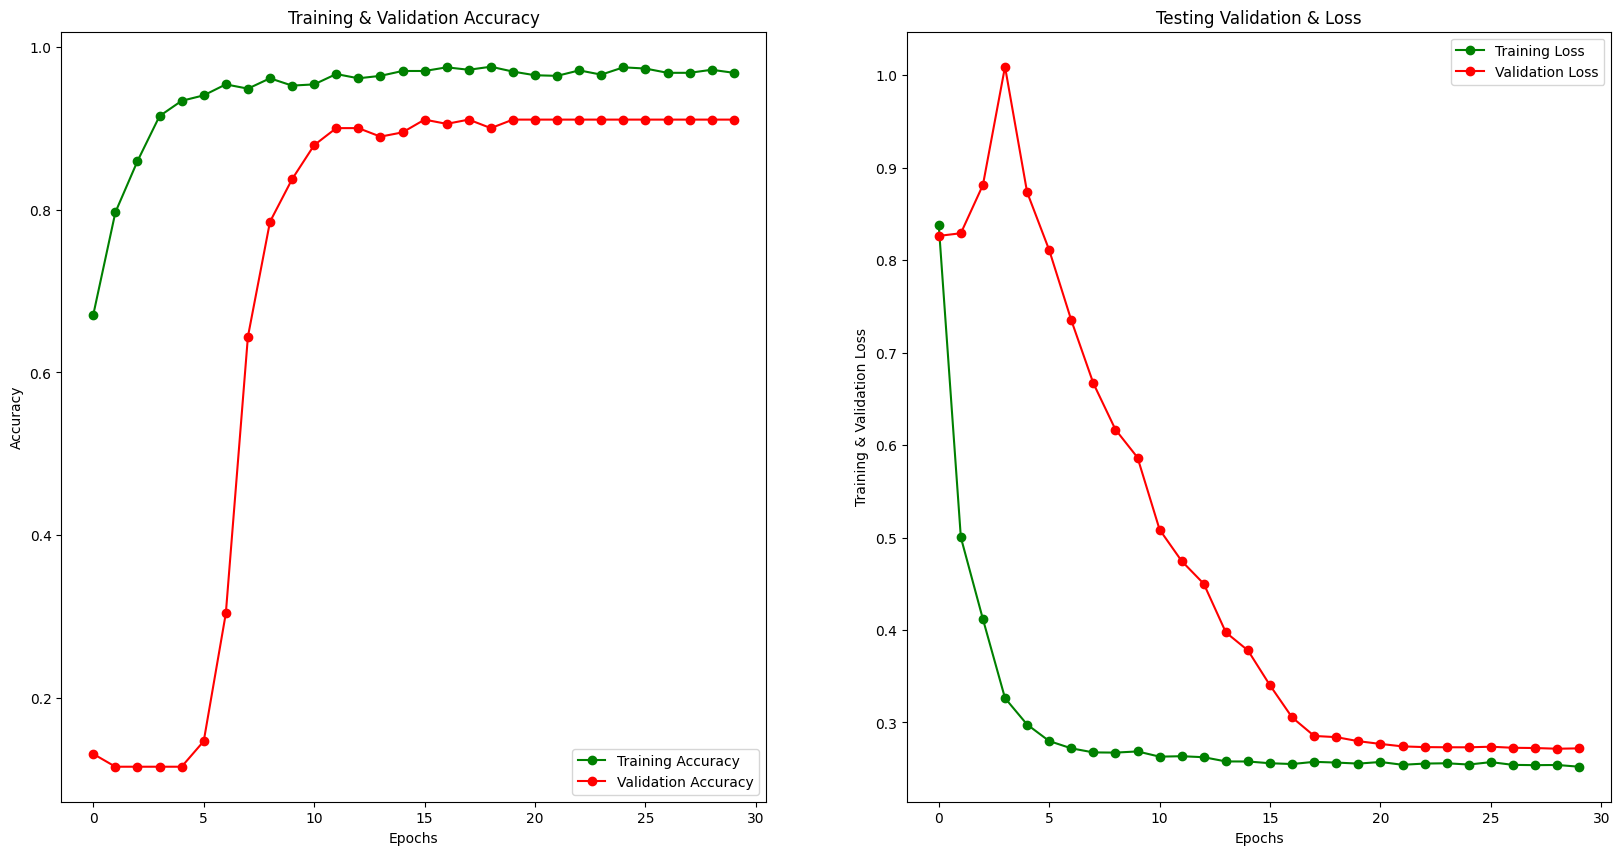

In [32]:
plot_history(history_3, size=(20,10), epochs = 30)

In [33]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['vessel', 'aneurysm']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['vessel', 'aneurysm']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

9/9 [==============================] - 0s 10ms/step
Test Set A
              precision    recall  f1-score   support

      vessel       0.95      0.94      0.95       101
    aneurysm       0.57      0.62      0.59        13

    accuracy                           0.90       114
   macro avg       0.76      0.78      0.77       114
weighted avg       0.91      0.90      0.91       114


Test Set B
              precision    recall  f1-score   support

      vessel       0.95      0.94      0.94       238
    aneurysm       0.55      0.60      0.57        30

    accuracy                           0.90       268
   macro avg       0.75      0.77      0.76       268
weighted avg       0.90      0.90      0.90       268

Test Set A
[[95  6]
 [ 5  8]]

Test Set B
[[223  15]
 [ 12  18]]


## Oversampling

In [34]:
get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ['vessel', 'aneurysm'])


Train
{(0, 1): 150, (1, 0): 1185}  ['vessel', 'aneurysm']

Val
{(0, 1): 22, (1, 0): 169}  ['vessel', 'aneurysm']

Test A
{(0, 1): 13, (1, 0): 101}  ['vessel', 'aneurysm']

Test B
{(0, 1): 30, (1, 0): 238}  ['vessel', 'aneurysm']


In [35]:
X_train_oversample = []
y_train_oversample = []

for X, y in zip(X_train,y_train):
    if y[1] == 1: 
        for i in range(7):
            X_train_oversample.append(X)
            y_train_oversample.append(y)
    else:
        X_train_oversample.append(X)
        y_train_oversample.append(y)

X_train_oversample = np.array(X_train_oversample).reshape(-1, image_size, image_size, image_size)
y_train_oversample = np.array(y_train_oversample)

In [37]:
get_label_counts(y_train_oversample,y_val,y_test_A,y_test_B,class_names = ['vessel', 'aneurysm'])


Train
{(0, 1): 1050, (1, 0): 1185}  ['vessel', 'aneurysm']

Val
{(0, 1): 22, (1, 0): 169}  ['vessel', 'aneurysm']

Test A
{(0, 1): 13, (1, 0): 101}  ['vessel', 'aneurysm']

Test B
{(0, 1): 30, (1, 0): 238}  ['vessel', 'aneurysm']


In [38]:
model = build_basic_model(input_shape = (image_size,image_size,image_size), num_classes = 2, loss="categorical_crossentropy",final_activation="softmax")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        8096      
                                                                 
 batch_normalization_15 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_16 (Ba  (None, 14, 14, 64)       

In [39]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./oversample_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./oversample_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [40]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 25,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train_oversample)

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:2092: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (2235, 28, 28, 28) (28 channels).
  warnings.warn(


In [41]:
history_4 = model.fit(datagen.flow(X_train_oversample,y_train_oversample, batch_size = 32), epochs = 30 ,  validation_data = (X_val, y_val) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2235, 28, 28, 28) (28 channels).
  warnings.warn(


Epoch 1/30
70/70 [==============================] - 5s 63ms/step - loss: 0.7453 - accuracy: 0.6890 - val_loss: 0.5089 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 2/30
 1/70 [..............................] - ETA: 5s - loss: 0.4526 - accuracy: 0.7500

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


70/70 [==============================] - 4s 60ms/step - loss: 0.5180 - accuracy: 0.7374 - val_loss: 0.7518 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 3/30
70/70 [==============================] - ETA: 0s - loss: 0.4466 - accuracy: 0.7848
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
70/70 [==============================] - 4s 61ms/step - loss: 0.4466 - accuracy: 0.7848 - val_loss: 1.1503 - val_accuracy: 0.8848 - lr: 0.0010
Epoch 4/30
70/70 [==============================] - 4s 60ms/step - loss: 0.3589 - accuracy: 0.8416 - val_loss: 1.2833 - val_accuracy: 0.8848 - lr: 3.0000e-04
Epoch 5/30
70/70 [==============================] - ETA: 0s - loss: 0.3198 - accuracy: 0.8617
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
70/70 [==============================] - 4s 60ms/step - loss: 0.3198 - accuracy: 0.8617 - val_loss: 0.8363 - val_accuracy: 0.8848 - lr: 3.0000e-04
Epoch 6/30
70/70 [==============================] - 4s 60ms/step - lo

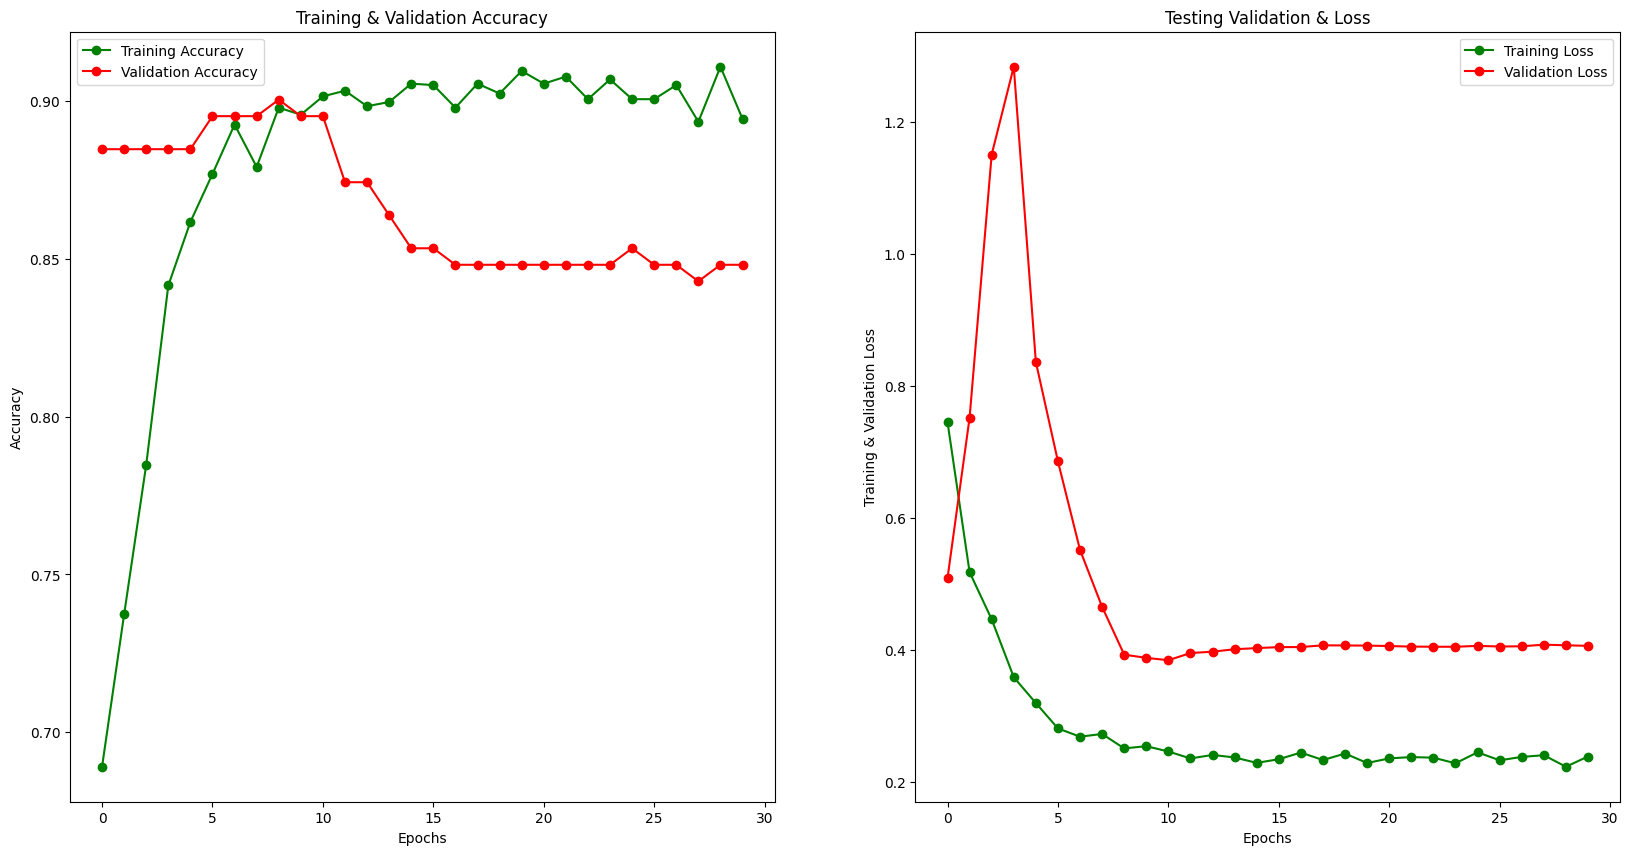

In [42]:
plot_history(history_4, size=(20,10), epochs = 30)

In [43]:
best_model = keras.models.load_model("./oversample_models/best_model_epoch_11.h5")

In [44]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['vessel', 'aneurysm']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['vessel', 'aneurysm']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

9/9 [==============================] - 0s 10ms/step
Test Set A
              precision    recall  f1-score   support

      vessel       0.96      0.88      0.92       101
    aneurysm       0.43      0.69      0.53        13

    accuracy                           0.86       114
   macro avg       0.69      0.79      0.72       114
weighted avg       0.90      0.86      0.87       114


Test Set B
              precision    recall  f1-score   support

      vessel       0.95      0.87      0.91       238
    aneurysm       0.37      0.60      0.46        30

    accuracy                           0.84       268
   macro avg       0.66      0.73      0.68       268
weighted avg       0.88      0.84      0.86       268

Test Set A
[[89 12]
 [ 4  9]]

Test Set B
[[207  31]
 [ 12  18]]


## Oversampling + Mixup

In [45]:
model = build_basic_model(input_shape = (image_size,image_size,image_size), num_classes = 2, loss="categorical_crossentropy",final_activation="softmax")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 32)        8096      
                                                                 
 batch_normalization_20 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 dropout_16 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_21 (Ba  (None, 14, 14, 64)       

In [46]:
X_train_mixup, y_train_mixup = generate_training_mixup_images(X_train_oversample, y_train_oversample, 3)

In [47]:
X_train_mixup = np.array(X_train_mixup).reshape(-1, image_size, image_size, image_size)
y_train_mixup = np.array(y_train_mixup)

In [48]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./oversample_mixup_models/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./oversample_mixup_models/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [49]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 25,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train_mixup)

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:2092: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (6705, 28, 28, 28) (28 channels).
  warnings.warn(


In [50]:
X_val_oversample = []
y_val_oversample = []

for X, y in zip(X_val,y_val):
    if y[1] == 1: 
        for i in range(7):
            X_val_oversample.append(X)
            y_val_oversample.append(y)
    else:
        X_val_oversample.append(X)
        y_val_oversample.append(y)

X_val_oversample = np.array(X_val_oversample).reshape(-1, image_size, image_size, image_size)
y_val_oversample = np.array(y_val_oversample)

In [51]:
X_val_mixup, y_val_mixup = generate_training_mixup_images(X_val_oversample, y_val_oversample, 3)

In [52]:
X_val_mixup = np.array(X_train_mixup).reshape(-1, image_size, image_size, image_size)
y_val_mixup = np.array(y_train_mixup)

In [53]:
history_5 = model.fit(datagen.flow(X_train_mixup,y_train_mixup, batch_size = 32), epochs = 30 ,  validation_data = datagen.flow(X_val_mixup, y_val_mixup) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (6705, 28, 28, 28) (28 channels).
  warnings.warn(


Epoch 1/30
210/210 [==============================] - 22s 102ms/step - loss: 0.6834 - accuracy: 0.6853 - val_loss: 0.6649 - val_accuracy: 0.6306 - lr: 0.0010
Epoch 2/30
  2/210 [..............................] - ETA: 10s - loss: 0.5878 - accuracy: 0.7031

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - 22s 105ms/step - loss: 0.5068 - accuracy: 0.7776 - val_loss: 0.6453 - val_accuracy: 0.5399 - lr: 0.0010
Epoch 3/30
210/210 [==============================] - 22s 107ms/step - loss: 0.4433 - accuracy: 0.8262 - val_loss: 0.4124 - val_accuracy: 0.8506 - lr: 0.0010
Epoch 4/30
210/210 [==============================] - 23s 108ms/step - loss: 0.4060 - accuracy: 0.8552 - val_loss: 0.6451 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 5/30
210/210 [==============================] - 22s 107ms/step - loss: 0.3750 - accuracy: 0.8793 - val_loss: 0.3417 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 6/30
210/210 [==============================] - 22s 105ms/step - loss: 0.3588 - accuracy: 0.8872 - val_loss: 0.3990 - val_accuracy: 0.8732 - lr: 0.0010
Epoch 7/30
210/210 [==============================] - 22s 105ms/step - loss: 0.3390 - accuracy: 0.9020 - val_loss: 0.3150 - val_accuracy: 0.9220 - lr: 0.0010
Epoch 8/30
210/210 [==============================] - 22s 105ms

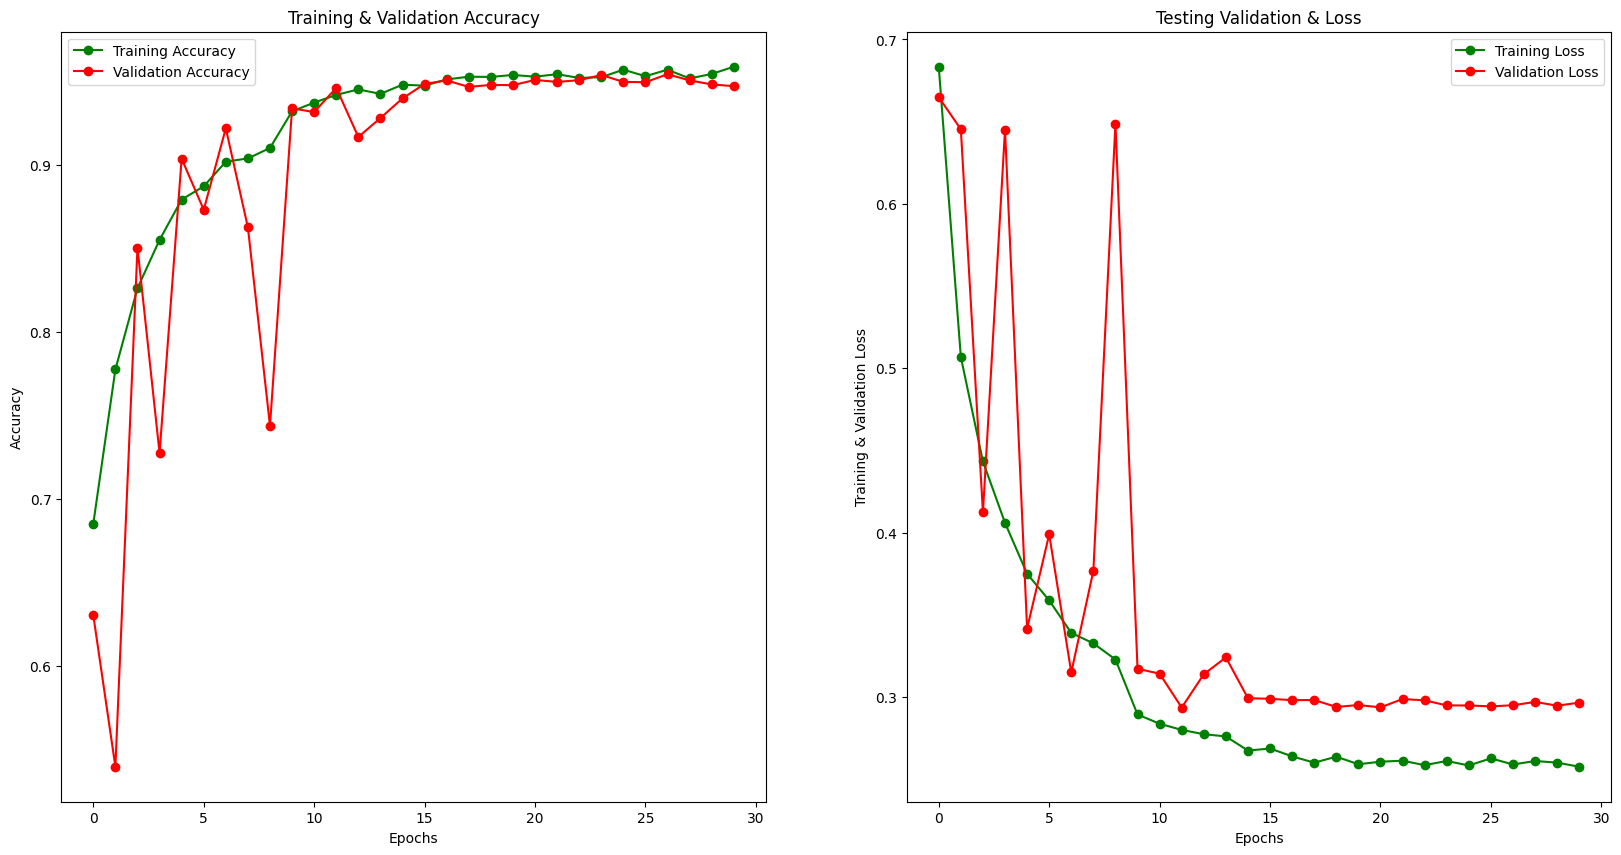

In [54]:
plot_history(history_5, size=(20,10), epochs = 30)

In [60]:
best_model = keras.models.load_model("./oversample_mixup_models/best_model_epoch_12.h5")

In [61]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['vessel', 'aneurysm']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['vessel', 'aneurysm']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

9/9 [==============================] - 0s 8ms/step
Test Set A
              precision    recall  f1-score   support

      vessel       0.96      0.92      0.94       101
    aneurysm       0.53      0.69      0.60        13

    accuracy                           0.89       114
   macro avg       0.74      0.81      0.77       114
weighted avg       0.91      0.89      0.90       114


Test Set B
              precision    recall  f1-score   support

      vessel       0.96      0.91      0.94       238
    aneurysm       0.50      0.70      0.58        30

    accuracy                           0.89       268
   macro avg       0.73      0.81      0.76       268
weighted avg       0.91      0.89      0.90       268

Test Set A
[[93  8]
 [ 4  9]]

Test Set B
[[217  21]
 [  9  21]]


In [62]:
X_train_mixup, y_train_mixup = generate_training_mixup_images(X_train_oversample, y_train_oversample, 3)

In [63]:
X_train_mixup = np.array(X_train_mixup).reshape(-1, image_size, image_size, image_size)
y_train_mixup = np.array(y_train_mixup)

In [64]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
best_model = keras.callbacks.ModelCheckpoint(filepath='./oversample_mixup_models_2/best_model_epoch_{epoch:02d}.h5', save_best_only=True)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 5 == 0:  # or save after some epoch, each k-th epoch etc.
            self.model.save(f"./oversample_mixup_models_2/model_epoch_{epoch}.h5")

epoch_saver = CustomSaver()

In [65]:
model = keras.models.load_model("./oversample_mixup_models/best_model_epoch_12.h5")

In [66]:
history_6 = model.fit(datagen.flow(X_train_mixup,y_train_mixup, batch_size = 32), epochs = 30 ,  validation_data = datagen.flow(X_val_mixup, y_val_mixup) ,callbacks = [learning_rate_reduction,best_model,epoch_saver],)

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (6705, 28, 28, 28) (28 channels).
  warnings.warn(


Epoch 1/30
210/210 [==============================] - 22s 102ms/step - loss: 0.2770 - accuracy: 0.9414 - val_loss: 0.2949 - val_accuracy: 0.9315 - lr: 3.0000e-04
Epoch 2/30
  1/210 [..............................] - ETA: 16s - loss: 0.2635 - accuracy: 0.9062

c:\Users\Will Poulett\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


210/210 [==============================] - 22s 106ms/step - loss: 0.2730 - accuracy: 0.9415 - val_loss: 0.3340 - val_accuracy: 0.9275 - lr: 3.0000e-04
Epoch 3/30
210/210 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.9417
Epoch 3: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
210/210 [==============================] - 22s 106ms/step - loss: 0.2735 - accuracy: 0.9417 - val_loss: 0.3505 - val_accuracy: 0.9095 - lr: 3.0000e-04
Epoch 4/30
210/210 [==============================] - 22s 106ms/step - loss: 0.2685 - accuracy: 0.9488 - val_loss: 0.2932 - val_accuracy: 0.9512 - lr: 9.0000e-05
Epoch 5/30
210/210 [==============================] - 22s 104ms/step - loss: 0.2641 - accuracy: 0.9474 - val_loss: 0.2995 - val_accuracy: 0.9408 - lr: 9.0000e-05
Epoch 6/30
210/210 [==============================] - 22s 105ms/step - loss: 0.2628 - accuracy: 0.9469 - val_loss: 0.2875 - val_accuracy: 0.9524 - lr: 9.0000e-05
Epoch 7/30
210/210 [====================

In [67]:
best_model = keras.models.load_model("./oversample_mixup_models_2/best_model_epoch_06.h5")

In [68]:
predictions_A = best_model.predict(X_test_A)
predictions_B = best_model.predict(X_test_B)
# argmax([0.8,0.2]) = 0. 0 is "Normal"

print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['vessel', 'aneurysm']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['vessel', 'aneurysm']))

print("Test Set A")
print(confusion_matrix(argmax_array(y_test_A), argmax_array(predictions_A)))
print("\nTest Set B")
print(confusion_matrix(argmax_array(y_test_B), argmax_array(predictions_B)))

9/9 [==============================] - 0s 10ms/step
Test Set A
              precision    recall  f1-score   support

      vessel       0.95      0.96      0.96       101
    aneurysm       0.67      0.62      0.64        13

    accuracy                           0.92       114
   macro avg       0.81      0.79      0.80       114
weighted avg       0.92      0.92      0.92       114


Test Set B
              precision    recall  f1-score   support

      vessel       0.96      0.92      0.94       238
    aneurysm       0.54      0.70      0.61        30

    accuracy                           0.90       268
   macro avg       0.75      0.81      0.78       268
weighted avg       0.91      0.90      0.90       268

Test Set A
[[97  4]
 [ 5  8]]

Test Set B
[[220  18]
 [  9  21]]
